In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g29afe694f1+a272651890 	current w_2023_40 setup
alert_packet          g6041bd2d66 	current w_2023_40 setup
analysis_drp          g8a53795882+0c0064919b 	current w_2023_40 setup
analysis_tools        g01ff57b274+b4ae54b57f 	current w_2023_40 setup
ap_association        g9b2d7c2ad1+0898bae26d 	current w_2023_40 setup
ap_pipe               g9f065385ad+72c0e07383 	current w_2023_40 setup
ap_verify             g60239a501b+d279a3926c 	current w_2023_40 setup
astro_metadata_translator g0978aabd1f+0ffa813159 	current w_2023_40 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_40 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_40 setup
cbp                   ga32fcf49c8+650be1a39c 	current w_2023_40 setup
cell_coadds           g9faf7ed3f3+0c0064919b 	current w_2023_40 setup
coadd_utils           g337abbeb29+650be1a39c 	current w_2023_40 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = '../output_regular_flats/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = '{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'flat'
physical_filter = 'empty~empty' 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [15]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND physical_filter='{1}'".format(obs_type,physical_filter)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2022091200073
  physical_filter: 'empty~empty'
  obs_id: 'AT_O_20220912_000073'
  exposure_time: 5.0
  dark_time: 5.23524
  observation_type: 'flat'
  observation_reason: 'flat'
  day_obs: 20220912
  seq_num: 73
  seq_start: 73
  seq_end: 73
  group_name: '2022-09-12T19:42:27.034'
  group_id: 2429413470340000
  target_name: 'FlatField position'
  science_program: 'unknown'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  azimuth: 205.69844879650918
  zenith_angle: 51.002982796824654
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2022-09-12 19:42:27.110009', scale='tai', format='iso'), end=astropy.time.Time('2022-09-12 19:42:32.345000', scale='tai', format='iso'))
	 timespan:             [2022-09-12T19:42:27.110009, 2022-09-12T19:42:32.345000)
	 timespan.begin:       2022-09-12 19:42:27.110009
	 id:                   2022091200073
	 day_obs:              20220912
	 seq_num:              73
	 type-of-observation: 

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  834


In [17]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
829,2023100300327,AT_O_20231003_000327,20231003,327,2023-10-03 17:27:51.436009,2023-10-03 17:27:52.679,flat,FlatField position,empty~empty,51.025351,1.0,165.745978,-78.546278,None,unknown
830,2023100300328,AT_O_20231003_000328,20231003,328,2023-10-03 17:27:55.172983,2023-10-03 17:27:56.411,flat,FlatField position,empty~empty,51.025392,1.0,165.762382,-78.546299,None,unknown
831,2023100300329,AT_O_20231003_000329,20231003,329,2023-10-03 17:27:58.901991,2023-10-03 17:28:00.142,flat,FlatField position,empty~empty,51.025428,1.0,165.778815,-78.546318,None,unknown
832,2023100300330,AT_O_20231003_000330,20231003,330,2023-10-03 17:28:02.634982,2023-10-03 17:28:03.868,flat,FlatField position,empty~empty,51.025466,1.0,165.795239,-78.546339,None,unknown
833,2023100300331,AT_O_20231003_000331,20231003,331,2023-10-03 17:28:06.361013,2023-10-03 17:28:07.604,flat,FlatField position,empty~empty,51.025494,1.0,165.807573,-78.546356,None,unknown


Available dates: 

In [18]:
obs_year = 2023

In [19]:
obs_days_ = np.unique(np.sort(np.array(df_science.day_obs)))
obs_days = obs_days_[obs_days_>=int(str(obs_year)+'0101')]
print(obs_days)

[20230112 20230116 20230118 20230214 20230321 20230327 20230404 20230420
 20230425 20230509 20230510 20230523 20230524 20230525 20230705 20230706
 20230724 20230725 20230726 20230727 20230801 20230802 20230803 20230811
 20230816 20230817 20230823 20230829 20230830 20230911 20230912 20230913
 20230921 20230926 20230927 20231003]


Select date: 

In [20]:
obs_day = 20230926
df_selected = df_science[df_science.day_obs==obs_day]

Select exposures: 

In [21]:
seq_nums = np.sort(np.array(df_selected.seq_num))
print(seq_nums)

[353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373]


In [22]:
ids = np.sort(np.array(df_selected.id))
print(ids)

[2023092600353 2023092600354 2023092600355 2023092600356 2023092600357
 2023092600358 2023092600359 2023092600360 2023092600361 2023092600362
 2023092600363 2023092600364 2023092600365 2023092600366 2023092600367
 2023092600368 2023092600369 2023092600370 2023092600371 2023092600372
 2023092600373]


We test retrieving one of them: 

In [23]:
seq_num0 = seq_nums[-1]
exp_id0 = ids[-1]
print(exp_id0)

2023092600373


In [24]:
test_img = butler.get('flat', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

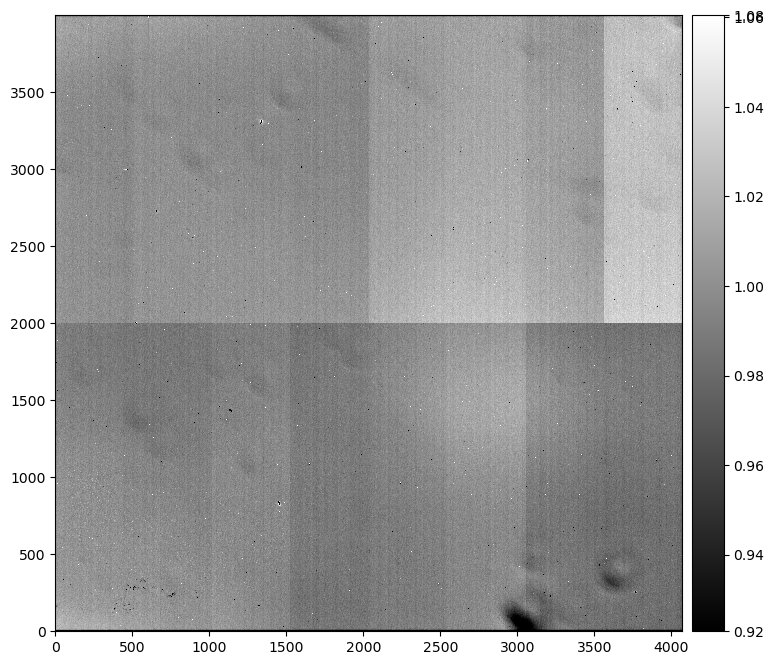

In [25]:
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

In [26]:
flat_data = test_img.getImage().array

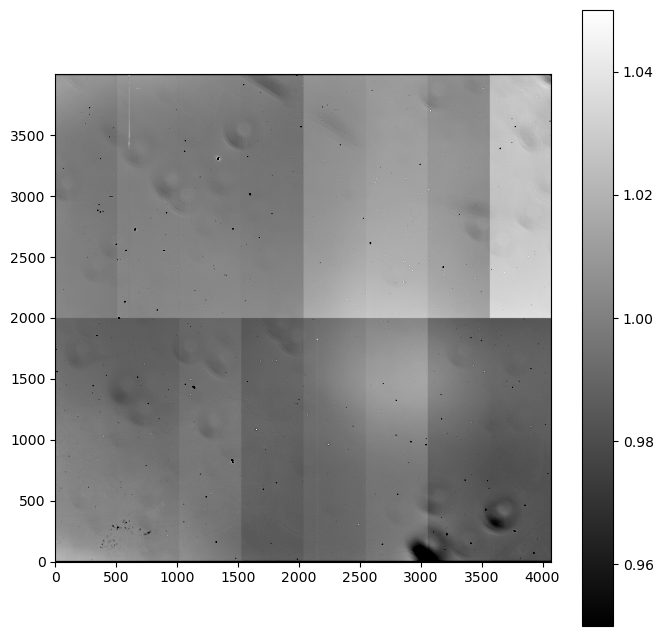

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_data,cmap="gray",origin='lower',vmin=0.95,vmax=1.05)
#ax.axhline(y=1000,ls='--')
#ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [28]:
md = test_img.getMetadata().toDict()

# Save in fits file 

In [29]:
outdir_ = outdir_label.format(obs_day)
outdir = os.path.join(outdir_base,outdir_)
if os.path.exists(outdir)==False:
    os.mkdir(outdir)

In [30]:
filename_out = 'flat_{0}_{1}.fits'.format(obs_day,physical_filter.replace('~','-'))
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(flat_data)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)

>>>>  output filename flat_20230926_empty-empty.fits
